# Deep learning project - Weather prediction

students:
1) Hakeem Abushqara 
2) Basel Mousa 

In [35]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


def prepare_sequences(features, targets, window):
    X, y = [], []
    for i in range(len(features)):
        # find the end of the current sequence
        end_ix = i + window
        # check if we are beyond the dataset
        if end_ix > len(features) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = features[i:end_ix], targets[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


cuda


# Data reading and preprocessing

In [36]:
df = pd.read_csv('london_weather.csv', parse_dates=['date'])

df.interpolate(method='bfill', inplace=True)  # fill in the missing values
df.interpolate(method='ffill', inplace=True)  # fill in the missing values

selected_columns = ['date', 'mean_temp',  'sunshine', 'precipitation', 'cloud_cover', 'global_radiation', 'min_temp', 'max_temp', 'pressure', 'snow_depth']  # select features to work with
data = df[selected_columns]


features = data.drop(columns=['date'])
targets = data[['mean_temp', 'sunshine']]


# split the dataset into train, validation, and test
X_temp, X_test, y_temp, y_test = train_test_split(features, targets, test_size=0.15, random_state=42, shuffle=False)

# split X_temp and y_temp to create the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=False)

# initialize the scalers
features_scaler = StandardScaler()

# fit the scaler on the training data
x_train_scaled = features_scaler.fit_transform(X_train)
# apply the same transformation to the test data
x_test_scaled = features_scaler.transform(X_test)
# appy on validation data
x_val_scaled = features_scaler.transform(X_val)

window_size = 7


# Our model - Bi-directional LSTM


1.  Bi-directional LSTM layer - number of layers = 2
2.  dropout - with 0.2 rate
3. linear layer with hidden size of 512



In [37]:
class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(WeatherRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)

        # dense Layer (fully connected, 2*hidden size because it is bidirectional)
        self.linear = nn.Linear(2*hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # initialize hidden and cell state
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.relu(out)
        out = self.dropout(out)
        # pass the output of the last time step to the classifier
        out = self.linear(out[:, -1, :])

        return out

# the class of the cusotmized loss function
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, predictions, targets):
        # extract predictions for each feature
        mean_temp_pred = predictions[:, 0]
        sunshine_pred = predictions[:, 1]

        # extract targets for each feature
        mean_temp_target = targets[:, 0]
        sunshine_target = targets[:, 1]

        # calculate MSE for each feature
        loss_mean_temp = F.mse_loss(mean_temp_pred, mean_temp_target, reduction='none')
        loss_sunshine = F.mse_loss(sunshine_pred, sunshine_target, reduction='none')

        # apply weights and calculate  weighted loss
        weighted_loss = self.weights[0] * loss_mean_temp + self.weights[1] * loss_sunshine

        # return the mean of the weighted loss
        return weighted_loss.mean()


###### those are the other two models we tried to use to get better results, but they gave the same resutls

# class WeatherRNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.5):
#         super(WeatherRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

    #     # Input layer
    #     self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
    #     self.relu = nn.ReLU()
    #     self.dropout = nn.Dropout(dropout_rate)

    #     # Intermediate layer (Dense + Activation + Dropout)
    #     self.dense_intermediate = nn.Linear(2*hidden_size, 2*hidden_size)  # Adjust the size as needed
    #     self.relu_intermediate = nn.ReLU()  # ReLU activation
    #     self.dropout_intermediate = nn.Dropout(dropout_rate)

    #     # Output layer (Dense + Activation)
    #     self.dense_output = nn.Linear(2*hidden_size, output_size)
    #     self.activation_output = nn.ReLU()  # Assuming ReLU for output; adjust according to your task

    # def forward(self, x):
    #     # Initialize hidden and cell state
    #     h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
    #     c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)

    #     # Input layer
    #     out, _ = self.lstm(x, (h0, c0))
    #     out = self.relu(out)
    #     out = self.dropout(out)

    #     # Intermediate layer
    #     out = self.dense_intermediate(out[:, -1, :])  # Taking the output of the last time step
    #     out = self.relu_intermediate(out)
    #     out = self.dropout_intermediate(out)

    #     # Output layer
    #     out = self.dense_output(out[:,:])
    #     out = self.activation_output(out)

    #     return out

# class WeatherRNN(nn.Module):
#     def __init__(self, input_size, hidden_sizes, bidirectional_sizes, output_size, dropout_rate=0.2):
#         super(WeatherRNN, self).__init__()

#         # Define bidirectional LSTM layers
#         self.bilstm1 = nn.LSTM(input_size, bidirectional_sizes[0], batch_first=True, bidirectional=True)
#         self.bilstm2 = nn.LSTM(bidirectional_sizes[0]*2, bidirectional_sizes[1], batch_first=True, bidirectional=True)
#         self.bilstm3 = nn.LSTM(bidirectional_sizes[1]*2, bidirectional_sizes[2], batch_first=True, bidirectional=True)

#         # Define additional layers
#         self.dropout = nn.Dropout(dropout_rate)
#         self.dense = nn.Linear(bidirectional_sizes[2]*2, output_size)
#         self.activation = nn.ReLU()

#     def forward(self, x):

#         # Pass through bidirectional LSTMs
#         x, _ = self.bilstm1(x)
#         x = self.dropout(x)
#         x, _ = self.bilstm2(x)
#         x = self.dropout(x)
#         x, _ = self.bilstm3(x)
#         x = self.dropout(x)

#         # linear layer and activation function
#         x = self.dense(x[:, -1, :])

#         return x



# Training and Evaluating the model

Epoch 1/40, Train Loss: 30.3188, Valid Loss: 16.0752
Epoch 2/40, Train Loss: 14.3127, Valid Loss: 12.2721
Epoch 3/40, Train Loss: 12.0917, Valid Loss: 10.7392
Epoch 4/40, Train Loss: 10.9074, Valid Loss: 9.9458
Epoch 5/40, Train Loss: 10.1311, Valid Loss: 9.4168
Epoch 6/40, Train Loss: 9.6286, Valid Loss: 8.9958
Epoch 7/40, Train Loss: 9.1832, Valid Loss: 8.8052
Epoch 8/40, Train Loss: 8.9496, Valid Loss: 8.6915
Epoch 9/40, Train Loss: 8.7841, Valid Loss: 8.5937
Epoch 10/40, Train Loss: 8.6924, Valid Loss: 8.5766
Epoch 11/40, Train Loss: 8.5824, Valid Loss: 8.5147
Epoch 12/40, Train Loss: 8.5159, Valid Loss: 8.4920
Epoch 13/40, Train Loss: 8.4461, Valid Loss: 8.4490
Epoch 14/40, Train Loss: 8.4079, Valid Loss: 8.3735
Epoch 15/40, Train Loss: 8.3069, Valid Loss: 8.3506
Epoch 16/40, Train Loss: 8.2650, Valid Loss: 8.3689
Epoch 17/40, Train Loss: 8.1859, Valid Loss: 8.2963
Epoch 18/40, Train Loss: 8.1045, Valid Loss: 8.2746
Epoch 19/40, Train Loss: 8.0286, Valid Loss: 8.2647
Epoch 20/40, 

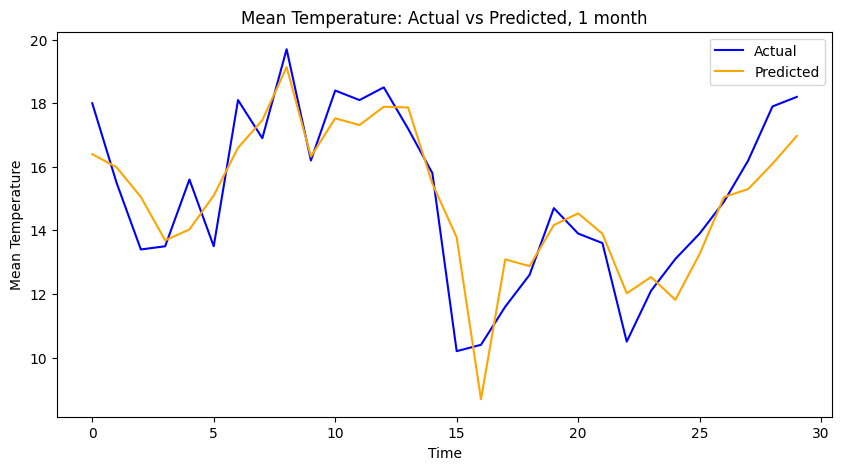

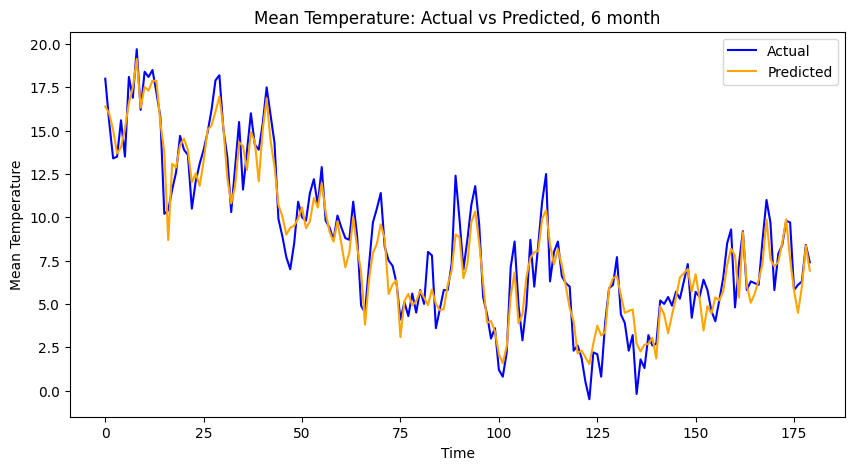

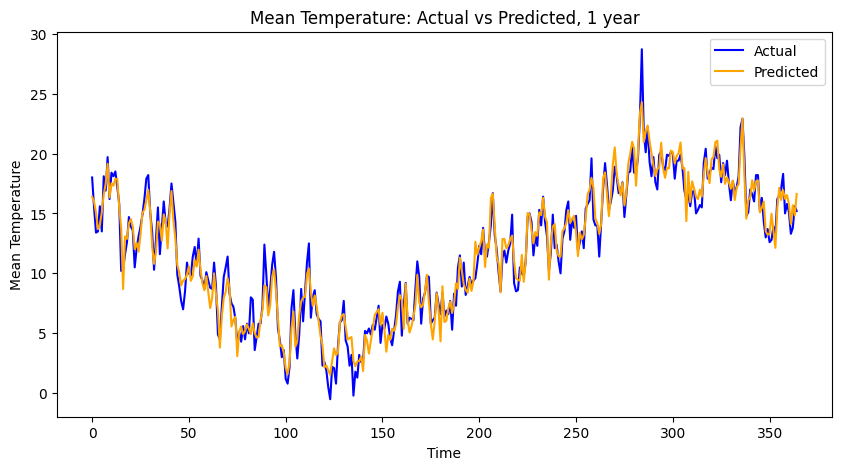

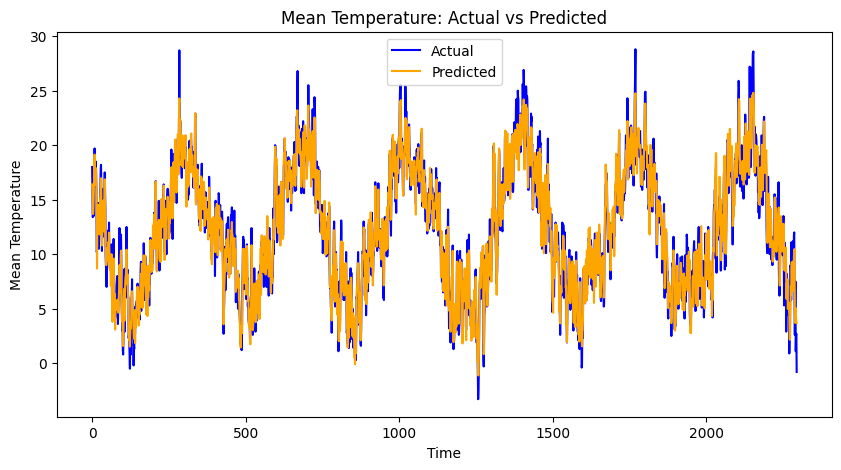

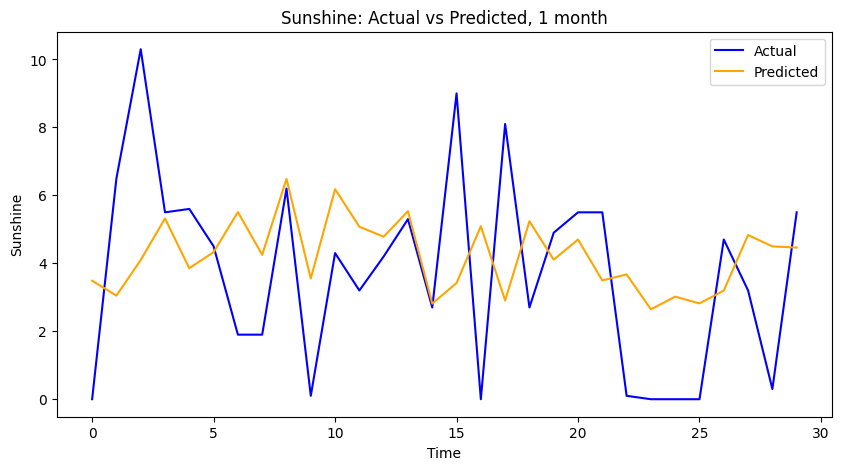

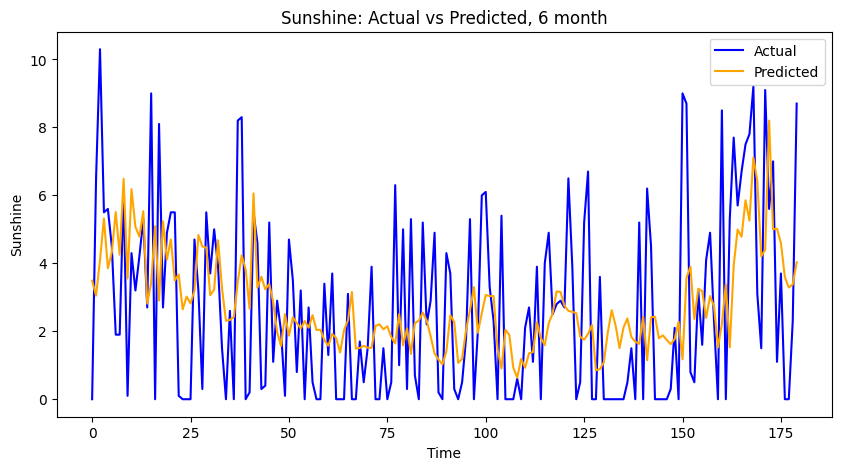

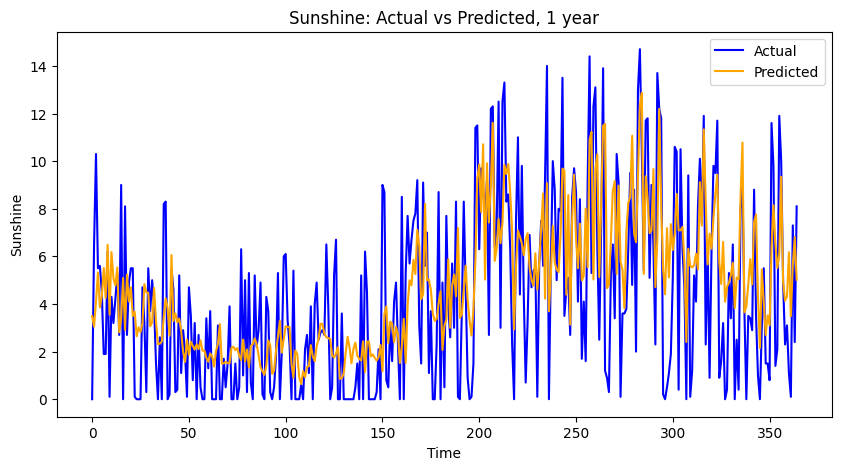

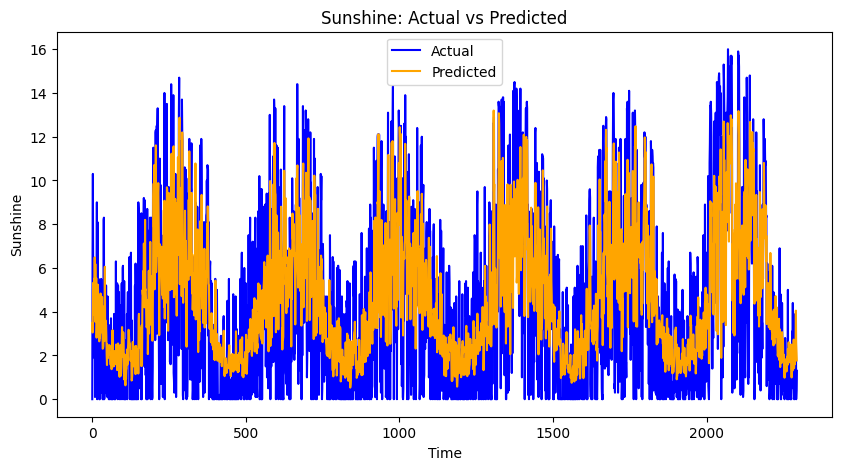

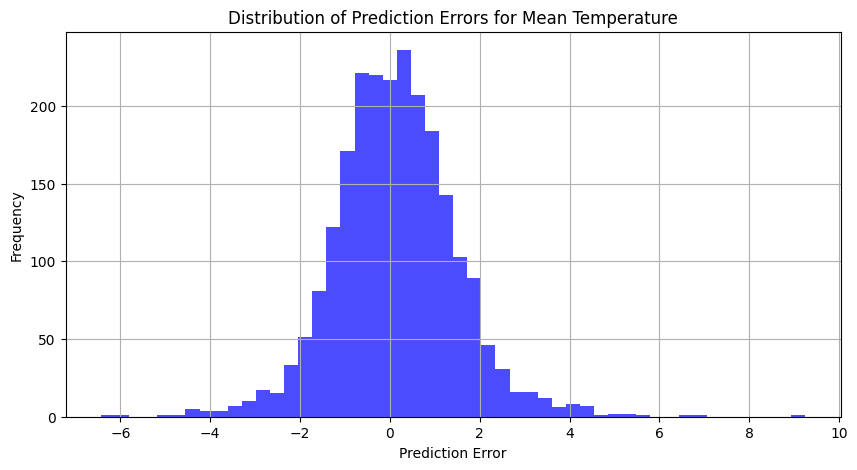

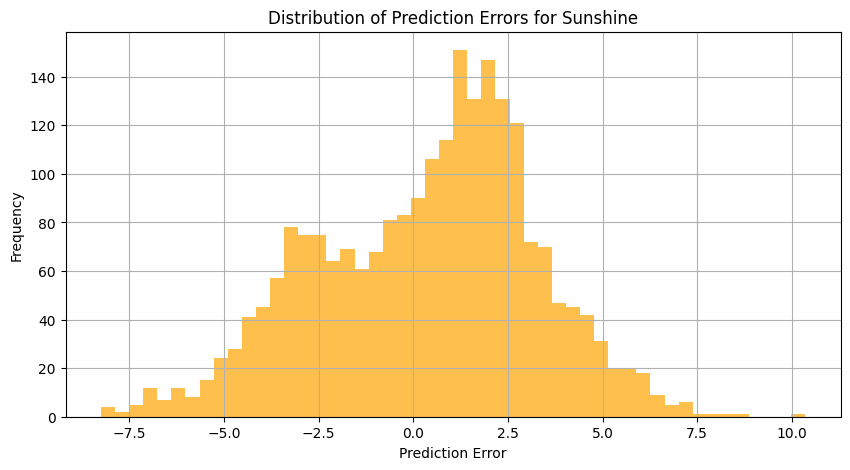

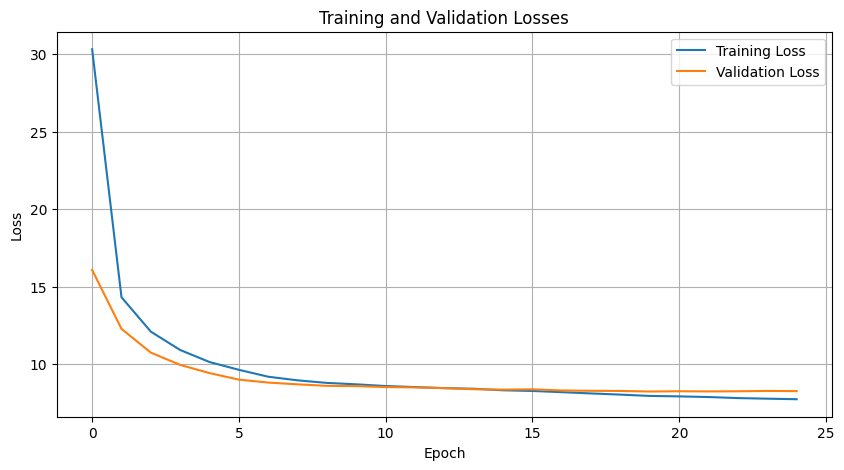

In [38]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_val = y_val.to_numpy()

# create sequences of the data
x_train_seq, y_train_seq = prepare_sequences(x_train_scaled, y_train, window_size)  # for train data
x_val_seq, y_val_seq = prepare_sequences(x_val_scaled, y_val, window_size)   # for valaidation data
x_test_seq, y_test_seq = prepare_sequences(x_test_scaled, y_test, window_size)  # for test data

# convert the sequences to tensors for train data
x_train_seq_tensor = torch.tensor(x_train_seq, dtype=torch.float)
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float)

# convert the sequences to tensors for validation data
x_val_seq_tensor = torch.tensor(x_val_seq, dtype=torch.float)
y_val_seq_tensor = torch.tensor(y_val_seq, dtype=torch.float)

# convert the sequences to tensors for test data
x_test_seq_tensor = torch.tensor(x_test_seq, dtype=torch.float)
y_test_seq_tensor = torch.tensor(y_test_seq, dtype=torch.float)

# create data loader for train data
train_dataset = TensorDataset(x_train_seq_tensor, y_train_seq_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)

# create data loader for validation data
val_dataset = TensorDataset(x_val_seq_tensor, y_val_seq_tensor)
valid_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# create data loader for test data
test_dataset = TensorDataset(x_test_seq_tensor, y_test_seq_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

input_size = x_train_seq.shape[2]  # number of features
hidden_size = 256
output_size = y_train_seq.shape[1]  # number of prediction targets
num_layers = 2

# for the third model
#model = WeatherRNN(input_size, hidden_sizes=[256, 128, 64], bidirectional_sizes=[32, 16, 8], output_size=output_size)

# initialize the model
model = WeatherRNN(input_size, hidden_size, output_size, num_layers)

# state_dict = torch.load('/content/lstm_model')
# model.load_state_dict(state_dict)

weights = torch.tensor([0.2, 0.8])  # more weight for sunshine error
criterion = WeightedMSELoss(weights)

# loss function and optimizer
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

# training loop
train_losses = []
valid_losses = []
best_val_loss = np.inf
epochs_without_improvement = 0
epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:

        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)

        # calculate the loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        # backward pass and optimize
        loss.backward()
        optimizer.step()

    ###### end of Epoch ########

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_valid_loss += loss.item()

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    if avg_valid_loss < best_val_loss:
        best_val_loss = avg_valid_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')

    if epochs_without_improvement >= 5:
        print("Early stopping due to no improvement.")
        break



# model evaluation loop
model.eval()  # set the model to evaluation mode
predictions = []
actuals = []
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # store predictions and actual values
        predictions.extend(outputs.cpu().detach().numpy())
        actuals.extend(targets.cpu().detach().numpy())

avg_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {avg_loss:.4f}')

# convert lists to numpy arrays for calculation
predictions = np.array(predictions)
actuals = np.array(actuals)

# calculate results by different metrics
# MSE
mse = mean_squared_error(actuals, predictions)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(actuals, predictions)

# R-squared
r_squared = r2_score(actuals, predictions)

# print the metrics results
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r_squared:.4f}')


torch.save(model.state_dict(), 'lstm_model')

actuals_mean_temp = actuals[:, 0]
predictions_mean_temp = predictions[:, 0]

actuals_precipitation = actuals[:, 1]
predictions_precipitation = predictions[:, 1]

# Plot for mean temperature

# for one month
plt.figure(figsize=(10, 5))
plt.plot(actuals_mean_temp[0:30], label='Actual', color='blue')
plt.plot(predictions_mean_temp[0:30], label='Predicted', color='orange')
plt.title('Mean Temperature: Actual vs Predicted, 1 month')
plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

# for 6 month
plt.figure(figsize=(10, 5))
plt.plot(actuals_mean_temp[0:180], label='Actual', color='blue')
plt.plot(predictions_mean_temp[0:180], label='Predicted', color='orange')
plt.title('Mean Temperature: Actual vs Predicted, 6 month')
plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

# for one year
plt.figure(figsize=(10, 5))
plt.plot(actuals_mean_temp[0:365], label='Actual', color='blue')
plt.plot(predictions_mean_temp[0:365], label='Predicted', color='orange')
plt.title('Mean Temperature: Actual vs Predicted, 1 year')
plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

# all the predictions
plt.figure(figsize=(10, 5))
plt.plot(actuals_mean_temp, label='Actual', color='blue')
plt.plot(predictions_mean_temp, label='Predicted', color='orange')
plt.title('Mean Temperature: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

# plot for sunshine

# for one month
plt.figure(figsize=(10, 5))
plt.plot(actuals_precipitation[0:30], label='Actual', color='blue')
plt.plot(predictions_precipitation[0:30], label='Predicted', color='orange')
plt.title('Sunshine: Actual vs Predicted, 1 month')
plt.xlabel('Time')
plt.ylabel('Sunshine')
plt.legend()
plt.show()

# for 6 month
plt.figure(figsize=(10, 5))
plt.plot(actuals_precipitation[0:180], label='Actual', color='blue')
plt.plot(predictions_precipitation[0:180], label='Predicted', color='orange')
plt.title('Sunshine: Actual vs Predicted, 6 month')
plt.xlabel('Time')
plt.ylabel('Sunshine')
plt.legend()
plt.show()

# for one year
plt.figure(figsize=(10, 5))
plt.plot(actuals_precipitation[0:365], label='Actual', color='blue')
plt.plot(predictions_precipitation[0:365], label='Predicted', color='orange')
plt.title('Sunshine: Actual vs Predicted, 1 year')
plt.xlabel('Time')
plt.ylabel('Sunshine')
plt.legend()
plt.show()

# all the predictions
plt.figure(figsize=(10, 5))
plt.plot(actuals_precipitation, label='Actual', color='blue')
plt.plot(predictions_precipitation, label='Predicted', color='orange')
plt.title('Sunshine: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Sunshine')
plt.legend()
plt.show()

# calculate differences/errors
errors_mean_temp = predictions[:, 0] - actuals[:, 0]
errors_sunshine = predictions[:, 1] - actuals[:, 1]

# plot distribution of errors for mean_temp
plt.figure(figsize=(10, 5))
plt.hist(errors_mean_temp, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Prediction Errors for Mean Temperature')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# plot distribution of errors for sunshine
plt.figure(figsize=(10, 5))
plt.hist(errors_sunshine, bins=50, alpha=0.7, color='orange')
plt.title('Distribution of Prediction Errors for Sunshine')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# plot train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
